### Demo: Brain Stimulation Simulation with The Virtual Brain 

> Authors: **Anaïs Halimi & Jil Meier**

> Charité – Universitätsmedizin Berlin - Brain Simulation Section: **Prof. Petra Ritter**

### Introduction

This demo introduces a `region-based simulation on TVB` with a `stimulus` targeting a cortical brain region. 

### Setup

In [1]:
%pylab inline

# install TVB locally 
!pip install -U tvb-library
!pip install tvb-data

# TVB functions
from tvb.simulator.lab import *
from tvb.basic.neotraits.api import NArray, List, Range, Final

# python functions
import os
import numpy as np
import scipy.io as sio
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 636 kB 5.2 MB/s eta 0:00:01
ERROR: tvb-widgets 1.2.0 has requirement ipympl>0.8.5, but you'll have ipympl 0.8.5 which is incompatible.
ERROR: tvb-widgets 1.2.0 has requirement ipywidgets==7.7.2, but you'll have ipywidgets 7.6.5 which is incompatible.
ERROR: tvb-framework 2.8.1.1 has requirement siibra==0.4a35, but you'll have siibra 0.4a58 which is incompatible.
ERROR: tvb-ext-xircuits 1.0.2 has requirement jupyter-server<2,>=1.16.0, but you'll have jupyter-server 1.13.5 which is incompatible.
ERROR: tvb-ext-xircuits 1.0.2 has requirement jupyterlab-widgets==1.1.0, but you'll have jupyterlab-widgets 1.0.2 which is incompatible.


### Connectivity

#### Load connectivity

In [2]:
# default TVB connectivity 
conn = connectivity.Connectivity.from_file() 

2024-05-03 15:58:24,984 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


#### Brain regions in the connectivity

In [3]:
# check the regions number
conn.region_labels.shape

(76,)

In [4]:
# check the regions list
conn.region_labels

array(['rA1', 'rA2', 'rAMYG', 'rCCA', 'rCCP', 'rCCR', 'rCCS', 'rFEF',
       'rG', 'rHC', 'rIA', 'rIP', 'rM1', 'rPCI', 'rPCIP', 'rPCM', 'rPCS',
       'rPFCCL', 'rPFCDL', 'rPFCDM', 'rPFCM', 'rPFCORB', 'rPFCPOL',
       'rPFCVL', 'rPHC', 'rPMCDL', 'rPMCM', 'rPMCVL', 'rS1', 'rS2',
       'rTCC', 'rTCI', 'rTCPOL', 'rTCS', 'rTCV', 'rV1', 'rV2', 'rCC',
       'lA1', 'lA2', 'lAMYG', 'lCCA', 'lCCP', 'lCCR', 'lCCS', 'lFEF',
       'lG', 'lHC', 'lIA', 'lIP', 'lM1', 'lPCI', 'lPCIP', 'lPCM', 'lPCS',
       'lPFCCL', 'lPFCDL', 'lPFCDM', 'lPFCM', 'lPFCORB', 'lPFCPOL',
       'lPFCVL', 'lPHC', 'lPMCDL', 'lPMCM', 'lPMCVL', 'lS1', 'lS2',
       'lTCC', 'lTCI', 'lTCPOL', 'lTCS', 'lTCV', 'lV1', 'lV2', 'lCC'],
      dtype='<U128')

#### Choose a region

In [5]:
# select LH primary motor cortex example 'lM1'
conn.region_labels[50]  

'lM1'

### Stimulus

#### Choose a stimulus weighting 

In [6]:
# number of regions in the connectivity
weighting = numpy.zeros((76, )) 

# attribution of a stimulus intensity in the targeted region 
weighting[[50]] = 0.1          

#### Define the stimulus parameters

In [7]:
# Pulse Train type of stimulus: pulse train, offset with respect to the time axis
eqn_t = equations.PulseTrain()

# onset of the stimulus at 1500 ms
eqn_t.parameters['onset'] = 1500

# repetition of the stimulus every 1000 ms
eqn_t.parameters['T'] = 1000.0 

# length of the stimulus of 50 ms
eqn_t.parameters['tau'] = 50.0 

#### Define the stimulus spatial and temporal components

In [8]:
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=conn,
    weight=weighting)

#### Vizualise the stimulus

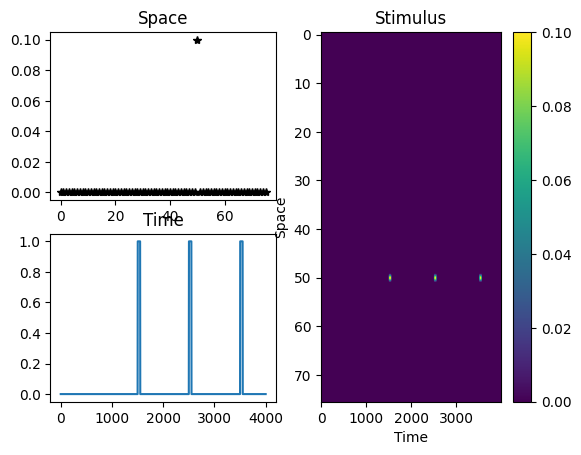

In [9]:
# configure space and time
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., 4e3, 1)) 

# plot the repetitive pulse train stimulus targetting the region selected
plot_pattern(stimulus)

We loaded and defined the parameters of our `connectivity` and `stimulus`.  

Let's `run our simulation`now!

### Simulation 

In [10]:
sim = simulator.Simulator(
    
    model=models.Generic2dOscillator(a=numpy.array([0.3]), tau=numpy.array([2])), 
    # dynamic system model describing one neural mass (m=1) with two state variables (n=2) 
    
    connectivity=conn,
    # connectivity defined previously (here default TVB connectivity)
    
    coupling=coupling.Difference(a=numpy.array([7e-4])),
    # difference coupling function between pre and post synaptic activity of the form
    
    integrator=integrators.HeunStochastic(dt=0.5, noise=noise.Additive(nsig=numpy.array([5e-5]))),
    # example of a predictor-corrector method with noise addition
    
    monitors=(
        monitors.TemporalAverage(period=1.0),
    # average of raw time series for each sampling period
        ),
    
    stimulus=stimulus,
    # implementing the stimulus defined previously
    
    simulation_length=4e3, 
    # length of the simulation in ms
    
).configure()

(tavg_time, tavg_data),  = sim.run()

### Plot the results

#### Time series plot

Text(0.5, 0, 'Time (ms)')

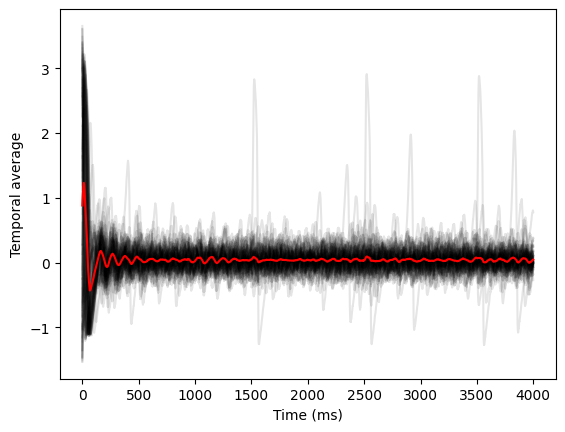

In [11]:
# propagation of the stimulus in the cortical regions
figure()

# individual region time series superposed in black 
plot(tavg_time, tavg_data[:, 0, :, 0], 'k', alpha=0.1) 

# time series mean in red
plot(tavg_time, tavg_data[:, 0, :, 0].mean(axis=1), 'r', alpha=1) 
ylabel("Temporal average")
xlabel('Time (ms)')

#### Visualize the stimulus propagation on the surface brain
Credits to *John Griffiths* for the function to visualise the propagation on the template brain (https://nbviewer.jupyter.org/urls/s3.amazonaws.com/replicating_spiegler2016/replicating_spiegler2016__html_nb.ipynb)

In [12]:
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):                 
  """
  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views

  view          : specify viewing angle

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number 

  shade_kwargs  : dictionary specifiying shading options
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  """
    
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

        
                                    # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # TVB default brain coordinates are yxz   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # reflect in the x axis
    vtx[:,0]*=-1
    
    # rotations for standard view options
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 
                            
    # apply rotations                           
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
                                    # 2. Sort out the data
                                    
                                    
    # no data: plot a vector of 1s
    # region data: create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
    # apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
                                    # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
    
                
                                    # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)
            

def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat


def get_rotation_matrix(rotation_axis, deg):

  '''Return rotation matrix in the x,y,or z plane'''
  th = -deg * (pi/180) # convert degrees to radians

  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])

#### Mapping regions on the respective space on the surface

The `initial stimulus` is on between [1500,1550] ms. 

We will plot the `evolution of the propagation of this initial stimulus on the brain surface`.

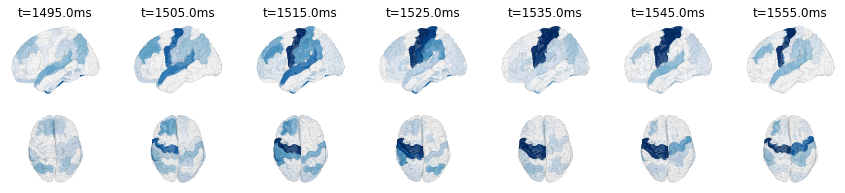

In [20]:
import copy
ctx = cortex.Cortex.from_file() 
# object Cortex: mesh surface defining 2D representation of convoluted cortical surface embedded in 3D space 

ctx.region_mapping_data.connectivity=conn

vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
# vtx: vertices
# tri: triangles
# rm: region mapping

fig, ax = plt.subplots(ncols=7, nrows=2,figsize=(15,3))
#cmap = cm.Blues
cmap = copy.copy(mpl.cm.get_cmap("Blues"))
cmap.set_under(color='w')
kws = {'edgecolors': 'k', 'vmin': 0.1, 'cmap': cmap, 
       'vmax': 0.6, 'alpha': None, 'linewidth': 0.01}

ts = [1495, 1505, 1515, 1525, 1535, 1545, 1555] 
# time states to plot 

for t_it,t in enumerate(ts):

    dat = np.absolute(tavg_data[t, 0, :, 0])
        
    plot_surface_mpl(vtx=vtx, tri=tri,data=dat,rm=rm,ax=ax[0][t_it],
                   shade_kwargs=kws,
                   view='lh_lat')   # lateral view
    
    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[1][t_it],
                   shade_kwargs=kws,
                   view='superior') # above view
    
    
    ax[0][t_it].set_title('t=%1.1fms' %t)

### Conclusion

The left/right `primary motor cortex` region targeted corresponds well to the `area with the highest activity impacted by the initial stimulus` (dark blue).

The `stimulus activity propagation` to other areas (premotor areas, sensory areas) is well visible.

We succeeded to do a brain stimulation simulation with The Virtual Brain!